In [14]:
import torch
from byol_pytorch import BYOL
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import HoverTool, ColumnDataSource
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
warnings.filterwarnings("ignore")

# Set parameters
bird_dir = '/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_a_Rotations/Gardner_Lab/Canary_Data/llb3/'
audio_files = bird_dir+'llb3_songs'
directory = bird_dir+ 'llb3_data_matrices/Python_Files'
analysis_path = '/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_a_Rotations/Gardner_Lab/Analysis/UMAP_Analysis'

# Parameters we set
num_spec = 1
window_size = 100
stride = 10

# Define the folder name
folder_name = f'{analysis_path}/Num_Spectrograms_{num_spec}_Window_Size_{window_size}_Stride_{stride}'

# Create the folder if it doesn't already exist
if not os.path.exists(folder_name+"/Plots/Window_Plots"):
    os.makedirs(folder_name+"/Plots/Window_Plots")
    print(f'Folder "{folder_name}" created successfully.')
else:
    print(f'Folder "{folder_name}" already exists.')



Folder "/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_a_Rotations/Gardner_Lab/Analysis/UMAP_Analysis/Num_Spectrograms_1_Window_Size_100_Stride_10" already exists.


In [15]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)  

In [16]:
# =============================================================================
# # If you are loading the results from a previous analysis, run the following lines of code
# =============================================================================

stacked_windows = np.load(folder_name+'/stacked_windows.npy') # An array of all the mini-spectrograms
labels_for_window = np.load(folder_name+'/labels_for_window.npy') # The syllable labels for each time point in each mini-spectrogram
embedding = np.load(folder_name+'/UMAP_Embedding.npy') # The pre-computed UMAP embedding (2 dimensional)
masked_frequencies = np.load(analysis_path+'/masked_frequencies_lowthresh_500_highthresh_7000.npy') # The frequencies we want to use for analysis. Excluding unnecessarily low and high frequencies
stacked_window_times = np.load(folder_name+'/stacked_window_times.npy') # The onsets and ending of each mini-spectrogram
    
# open the file for reading in binary mode
with open(folder_name+'/category_colors.pkl', 'rb') as f:
    # load the dictionary from the file using pickle.load()
    category_colors = pickle.load(f)   
    
# Each syllable is given a unique color. Each mini-spectrogram will have an average syllable color associated with it. This is the average RGB value across all unique syllables in the mini-spectrogram
mean_colors_per_minispec = np.load(folder_name+'/mean_colors_per_minispec.npy')


In [17]:
batch_size = 157
num_batches = int(stacked_windows.shape[0])
num_batches = int(stacked_windows.shape[0]/batch_size)
height = stacked_window_times.shape[1]
width = int(stacked_windows.shape[1]/height)


# x = stacked_windows[0:157,:]
# input_torch = x.reshape(batch_size, 1, height, width)
input_torch = stacked_windows.reshape(num_batches, batch_size, 1, height, width)
input_torch = torch.tensor(input_torch).float()
input_torch.shape


torch.Size([4, 157, 1, 100, 151])

In [20]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(16*75*75, 2)

    def forward(self, x):
        x = self.conv(x)
        # x = self.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [21]:
# resnet = models.resnet50(pretrained=True)
model = SimpleCNN()
model = model.to(device)
# resnet = resnet.to(device)
learner = BYOL(
    model,
    image_size = 151,
    projection_size = 2,           # the projection size
    projection_hidden_size = 100,   # the hidden dimension of the MLP for both the projection and prediction
)


In [22]:
num_epochs = 100

opt = torch.optim.Adam(learner.parameters(), lr=0.005)
loss_list = []
for i in range(num_epochs):
    batch_loss = []
    for b in np.arange(num_batches):
        # Extract the batch 
        input_torch_batch = input_torch[b, :, :, :].to(device)

        # Resize images to be square. Also make the images compatible with BYOL package by adding in 3 channels
        new_size = (151, 151)  # replace with your desired size
        resized_tensor = F.interpolate(input_torch_batch, size=new_size, mode='bilinear', align_corners=False)

        # Print the shape of the resized tensor
        # print(resized_tensor.shape)

        # extract the first dimension of the tensor
        first_dim = resized_tensor.shape[0]

        # create a new tensor by repeating the original tensor along the new dimensions
        new_tensor = resized_tensor.repeat(1, 3, 1, 1)
        loss = learner(new_tensor, return_embedding = False, return_projection = True)
        batch_loss.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()

    loss_list.append(np.mean(batch_loss))
    if i%10 == 0:
        print(f'Epoch {i}, Mean Batch Loss: {loss.item():.2f}')


Epoch 0, Mean Batch Loss: 1.49
Epoch 10, Mean Batch Loss: 0.68
Epoch 20, Mean Batch Loss: 1.21
Epoch 30, Mean Batch Loss: 1.16
Epoch 40, Mean Batch Loss: 1.24
Epoch 50, Mean Batch Loss: 0.99
Epoch 60, Mean Batch Loss: 0.83
Epoch 70, Mean Batch Loss: 1.57
Epoch 80, Mean Batch Loss: 1.49
Epoch 90, Mean Batch Loss: 1.27


In [23]:
projection_arr = []
embedding_arr = []
with torch.no_grad():
    for b in np.arange(num_batches):
        # Extract the batch 
        input_torch_batch = input_torch[b, :, :, :].to(device)

        # Resize images to be square. Also make the images compatible with BYOL package by adding in 3 channels
        new_size = (151, 151)  # replace with your desired size
        resized_tensor = F.interpolate(input_torch_batch, size=new_size, mode='bilinear', align_corners=False)

        # Print the shape of the resized tensor
        # print(resized_tensor.shape)

        # extract the first dimension of the tensor
        first_dim = resized_tensor.shape[0]

        # create a new tensor by repeating the original tensor along the new dimensions
        new_tensor = resized_tensor.repeat(1, 3, 1, 1)
        projection, embedding = learner(new_tensor, return_embedding = True)
        projection_arr.append(projection.cpu().detach().numpy())
        embedding_arr.append(embedding.cpu().detach().numpy())

In [24]:
projection_arr = np.concatenate(projection_arr, axis = 0)
embedding_arr = np.concatenate(embedding_arr, axis = 0)
print(projection_arr.shape)
print(embedding_arr.shape)

(628, 2)
(628, 90000)


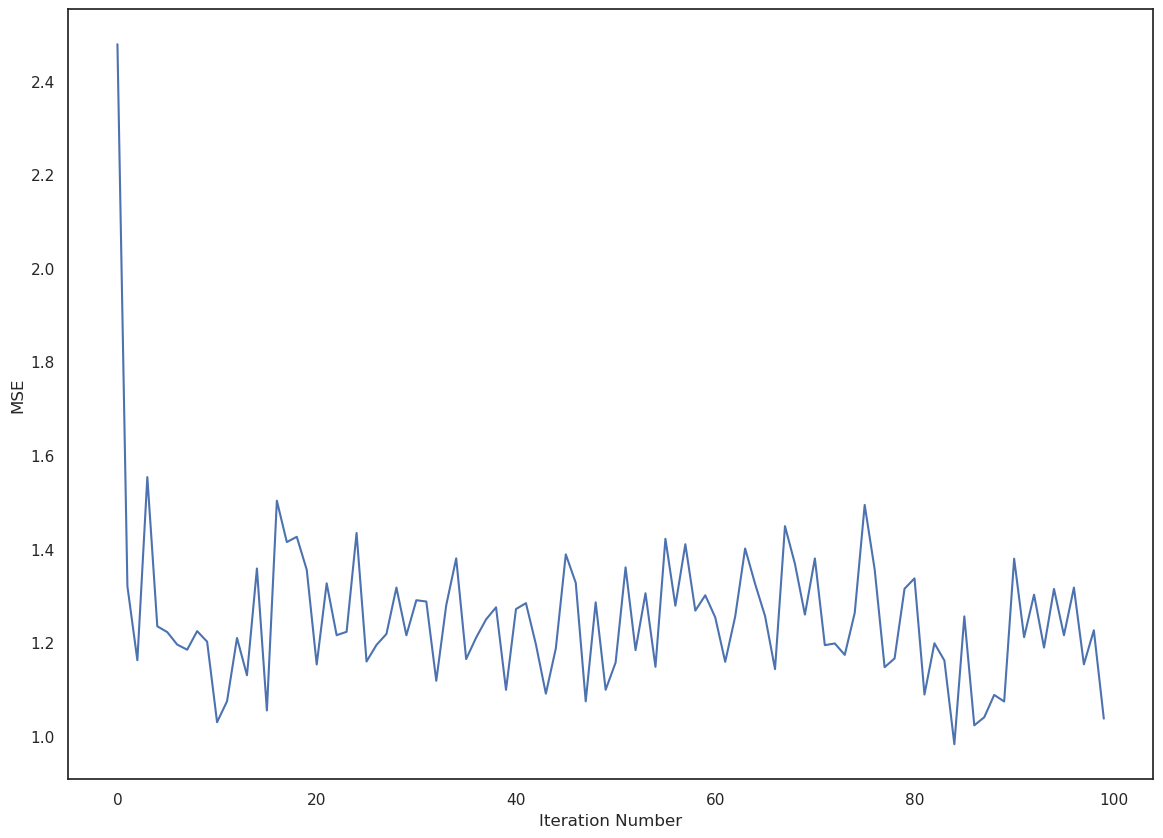

In [25]:
plt.figure()
plt.plot(loss_list)
plt.xlabel("Iteration Number")
plt.ylabel("MSE")
plt.show()

In [26]:
# Specify an HTML file to save the Bokeh image to.
output_file(filename=f'{folder_name}/Plots/byol.html')

# projection_arr = projection.clone().detach().numpy()
projection_arr = projection.cpu().detach().numpy()


# Convert the UMAP embedding to a Pandas Dataframe
spec_df = pd.DataFrame(projection_arr, columns=('x', 'y'))


# Create a ColumnDataSource from the data. This contains the UMAP embedding components and the mean colors per mini-spectrogram
source = ColumnDataSource(data=dict(x = projection_arr[:,0], y = projection_arr[:,1], colors=mean_colors_per_minispec))


# Create a figure and add a scatter plot
p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
p.scatter(x='x', y='y', size = 7, color = 'colors', source=source)

hover = p.select(dict(type=HoverTool))
hover.tooltips = """
    <div>
        <h3>@x, @y</h3>
        <div>
            <img
                src="@image" height="100" alt="@image" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""

p.add_tools(HoverTool(tooltips="""
"""))


# Set the image path for each data point
source.data['image'] = []
for i in np.arange(spec_df.shape[0]):
    source.data['image'].append(f'{folder_name}/Plots/Window_Plots/Window_{i}.png')

show(p)

save(p)


'/home/akapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_a_Rotations/Gardner_Lab/Analysis/UMAP_Analysis/Num_Spectrograms_1_Window_Size_100_Stride_10/Plots/byol.html'